In [3]:
import numpy as np
import numpy as np
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline, LinearNDInterpolator, NearestNDInterpolator
from scipy.integrate import odeint
import concurrent.futures, itertools
import matplotlib.pyplot as plt
import pickle, tqdm, functools
import vegas
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


## Definitions and EdS case

In [4]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_int = pickle.load(f)
fact=(2*np.pi)**3

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def alpha(k1,k2,cT):
    return 1+cT*k2/k1

def alphas(k1,k2,cT):
    return 1+0.5*cT*(k2/k1+k1/k2)

def beta(k1,k2,cT):
    t1=k1*k1+k2*k2+2*k1*k2*cT
    t2=k1*k2*cT
    t3=2.*k1*k1*k2*k2
    return t1*t2/t3


In [5]:
fx=0.1
fullt=np.linspace(-5,3, 100)
teval=10
idx_eta=np.abs(fullt - (0.)).argmin()
kref=0.1

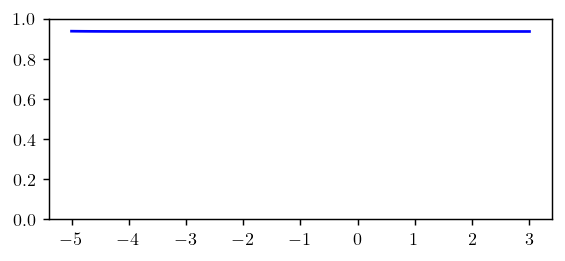

In [6]:
# this is solved fot k=0.1 (for which tildeeta = eta) and then I shift it using the smmetry
def lin_system(w,t):
    dc,Tc = w
    ddcdt = Tc
    dTcdt = -0.5*Tc+1.5*(1-fx)*dc
    return [ddcdt, dTcdt]
# Initial conditions
w0 = [1,1-3/5*fx]
# Solve the differential equation
tlin=np.linspace(fullt[0],fullt[-1],1000)

linsol = odeint(lin_system, w0, tlin)

g_c_int=interp1d(tlin,linsol[:,1]/linsol[:, 0],bounds_error=False,  fill_value='extrapolate')

plt.figure(figsize=(5,2), dpi=130);plt.ylim([0,1])
plt.plot(fullt, g_c_int(fullt), 'b', label=r'$\Theta$')
plt.show()

In [7]:
#--------
# 2nd order
#--------
def solve_second_order(triplet, return_timedep=False):
    k1 , k2, cT = triplet
    def F2_system(w, t):
        Fc2,Gc2 = w
        fact=(g_c_int(t-2*np.log(k1))+g_c_int(t-2*np.log(k2)))
        SF2=0.5*g_c_int(t-2*np.log(k2))*alpha(k1,k2,cT)+0.5*g_c_int(t-2*np.log(k1))*alpha(k2,k1,cT)
        dGc2dt = -(0.5+fact)*Gc2 + 1.5 *((1-fx)*Fc2) +g_c_int(t-2*np.log(k1))*g_c_int(t-2*np.log(k2))*beta(k1,k2,cT)
        dFc2dt = -fact*Fc2 + Gc2 + SF2
        return [dFc2dt, dGc2dt]
    Fc2_0=(5./7.+6/245*fx)*alphas(k1,k2,cT)+(2./7.-6/245*fx)*beta(k1,k2,cT)
    Gc2_0=(3./7-51/245*fx)*alphas(k1,k2,cT)+(4./7-96/245*fx)*beta(k1,k2,cT)
    sol = odeint(F2_system, [Fc2_0,Gc2_0], fullt, rtol=0.001)
    if return_timedep:
        return sol
    return sol[idx_eta]

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4628506089752D+01


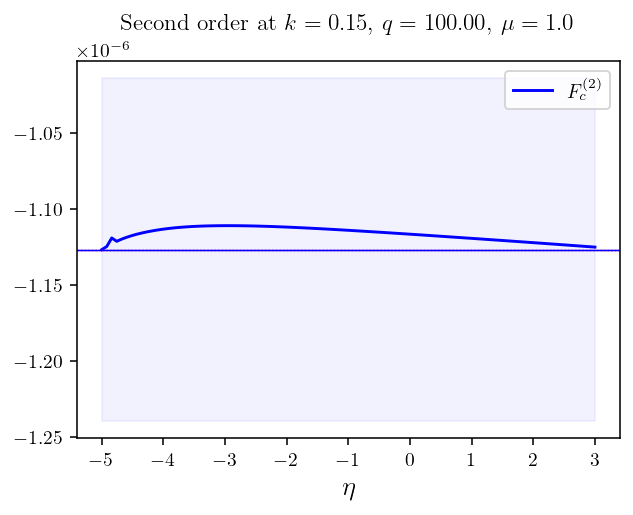

In [17]:
kp=0.15
qp=100
mup=1.
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq
sol=solve_second_order([qp,kMq,cT12], return_timedep=True)

plt.figure(figsize=(5,3.5), dpi=140)
plt.plot(fullt, sol[:,0], 'b', label=r'$F_c^{(2)}$')

Fc2_0=(5./7.+6/245*fx)*alphas(qp,kMq,cT12)+(2./7.-6/245*fx)*beta(qp,kMq,cT12)
def G2F2combo(k1,k2,cT):
    return [(5./7+6/245*fx)*alphas(k1,k2,cT)+(2./7-6/245*fx)*beta(k1,k2,cT),(3./7-3*17/245*fx)*alphas(k1,k2,cT)+(4./7-3*32/245*fx)*beta(k1,k2,cT)]
plt.axhline(Fc2_0, color='b', linestyle=':', linewidth=0.7)
plt.axhline(G2F2combo(qp,kMq,cT12)[0], color='m', linewidth=0.7)

plt.axhline(F2(kp,qp,mup), color='b', linewidth=0.7)
plt.fill_between(fullt, F2(kp,qp,mup)*(1-fx),F2(kp,qp,mup)*(1+fx), alpha=0.05, color='b')

# plt.axhline(F3(kp,qp,mup), color='g', linewidth=0.7)

plt.legend()
# plt.xlim([-8,8])

# plt.yscale('log')
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')

plt.show()

In [18]:
kp=0.15
qp=1000
mup=1.

print(solve_second_order([kp,qp,mup]), G2F2combo(kp,qp,mup))

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4660783283932D+01
[3334.32652647 3129.22503651] [3334.3334083333334, 3134.2734038333333]


In [11]:
#--------
# 3rd order
#--------
def DeltaF3_ennio(k,q,mu):
    x2=(k/q)**2;mu2=mu*mu
    num=4*(mu2-1)*x2*(-49*mu2+(5*mu2+22)*x2 +22)
    den=945*(x2*x2+(2-4*mu2)*x2+1)
    return num/den

def G2F2combo(k1,k2,cT):
    return [(5./7+6/245*fx)*alphas(k1,k2,cT)+(2./7-6/245*fx)*beta(k1,k2,cT),(3./7-3*17/245*fx)*alphas(k1,k2,cT)+(4./7-3*32/245*fx)*beta(k1,k2,cT)]

def solve_F3_for_k(triplet, return_timedep=False):
    k , q, mu = triplet
    
    ker2_k_mq_full=solve_second_order([k,q,-mu], return_timedep=True)
    ker2_k_q_full=solve_second_order([k,q,mu], return_timedep=True)
    # ker2_k_mq_full=np.tile(G2F2combo(k,q,-mu), (fullt.shape[0], 1))
    # ker2_k_q_full=np.tile(G2F2combo(k,q,mu), (fullt.shape[0], 1))
    def F3_system(w, t):

        Fc3,Gc3 = w
        fact=(g_c_int(t-2*np.log(k))+2*g_c_int(t-2*np.log(q)))

        idx_t_F3=np.abs(fullt - t).argmin()
        ker2_k_mq=ker2_k_mq_full[idx_t_F3]
        ker2_k_q=ker2_k_q_full[idx_t_F3]

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3=g_c_int(t-2*np.log(q))*alpha(q,kMq,cT)*ker2_k_mq[0]+alpha(kMq,q,cT)*ker2_k_mq[1]
        SG3=g_c_int(t-2*np.log(q))*beta(kMq,q,cT)*2*ker2_k_mq[1]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3+=g_c_int(t-2*np.log(q))*alpha(q,kPq,cT)*ker2_k_q[0]+alpha(kPq,q,cT)*ker2_k_q[1]
        SG3+=g_c_int(t-2*np.log(q))*beta(kPq,q,cT)*2*ker2_k_q[1]

        dFc3dt = -fact*Fc3 + Gc3 + SF3/3
        dGc3dt = -(0.5+fact)*Gc3 + 1.5*((1-fx)*Fc3) + SG3/3

        return [dFc3dt, dGc3dt]
    
    tsol=np.linspace(np.log(k/kref)-10,np.log(k/kref)+18,100)
    sol = odeint(F3_system, [F3(k,q,mu)-1/7*fx*DeltaF3_ennio(k,q,mu),F3(k,q,mu)-1/7*fx*DeltaF3_ennio(k,q,mu)], tsol, rtol=0.001)
    if return_timedep:
        return [tsol,sol[:,0]]
    return sol[idx_eta,0]

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658549218346D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658548652277D+01


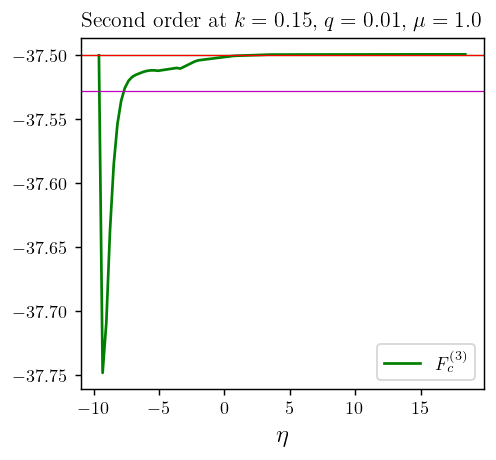

In [16]:
kp=0.15
qp=0.01
mup=1.
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq
solF3=solve_F3_for_k([kp,qp,mup], return_timedep=True)

plt.figure(figsize=(4,3.5), dpi=130)

plt.plot( solF3[0],solF3[1], 'g', label=r'$F_c^{(3)}$')

# plt.axhline(F2(kp,qp,mup), color='b', linewidth=0.7)
plt.axhline(F3(kp,qp,mup), color='g', linewidth=0.7)
plt.axhline(F3(kp,qp,mup)-1/7*fx*DeltaF3_ennio(kp,qp,mup), color='r', linewidth=0.7)
plt.axhline(F3(kp,qp,mup)-1/7*fx*DeltaF3_mio(kp,qp,mup), color='m', linewidth=0.7)

plt.legend()
# plt.ylim([F3(kp,qp,mup)*0.9,F3(kp,qp,mup)*1.1])

# plt.yscale('log')
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')

plt.show()

In [36]:
#--------
def onmu_int(mu, kev, q, calcP13=True, calcP22=True, EdS=False):
    P13=0
    if calcP13:
        if EdS:
            F3_val=F3(kev,q,mu)
        else:
            F3_val=solve_F3_for_k([kev,q,mu])
        # F3_val=F3(kev,q,mu)
        P13+=6*q*q*F3_val*Plin_int(q)*Plin_int(kev)
    kMq = np.sqrt(kev*kev + q*q - 2*kev*q*mu)
    kPq = np.sqrt(kev*kev + q*q + 2*kev*q*mu)
    P22=0
    if calcP22:
        if kMq>q:
            if EdS:
                F2_val=F2(kev,q,mu)
            else:
                cT12 = (kev*mu-q)/kMq
                F2_val=solve_second_order([q,kMq,cT12])[0]
            P22+=2*q*q*F2_val*F2_val*Plin_int(q)*Plin_int(kMq)
        if kPq>q:
            if EdS:
                F2_val=F2(kev,q,-mu)
            else:
                cT12 = -(kev*mu+q)/kPq
                F2_val=solve_second_order([q,kPq,cT12])[0]
            P22+=2*q*q*F2_val*F2_val*Plin_int(q)*Plin_int(kPq)
    return (P13+P22)*4*np.pi/fact
    
reslist22=[];reslist13=[]
kp=0.15
qlist=np.logspace(-5,-2,10)
for qEval in qlist:
    print(f'P22 at q={qEval:.2e}',end='\r')
    integ = vegas.Integrator([0., 1.],mpi=True, nproc=48)
    result = integ(functools.partial(onmu_int, kev=kp, q=qEval,calcP22=True, calcP13=False, EdS=False),neval=50)
    reslist22.append(result.mean)

    print(f'P13 at q={qEval:.2e}',end='\r')
    result = integ(functools.partial(onmu_int, kev=kp, q=qEval,calcP22=False, calcP13=True,EdS=False),neval=50)
    reslist13.append(result.mean)

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658549337271D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658548499807D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658551143667D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658555240428D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to

In [35]:
kp=0.15
qp=1.e-4
integ = vegas.Integrator([0., 1.],mpi=True, nproc=48)
result = integ(functools.partial(onmu_int, kev=kp, q=qp,calcP22=True, calcP13=False, EdS=False),neval=100)
res22=result.mean
print(f'P22={result},now P13')
result = integ(functools.partial(onmu_int, kev=kp, q=qp,calcP22=False, calcP13=True,EdS=False),neval=100)
res13=result.mean
print(f'P13={result}')
print(f'P22={res22:.3f}, -P13={-res13:.3f}, reldiff={(res22+res13)/res22:.0e}')

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658549112715D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658548723220D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658645180069D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.4838383838384D+01   r2 = -0.4658654035840D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.4838383838384D+01
      t not in interval tcur - hu (= r1) to

 P22=483.9(1.4),now P13
P13=-509.5(1.9)
P22=483.864, -P13=509.450, reldiff=-5e-02 

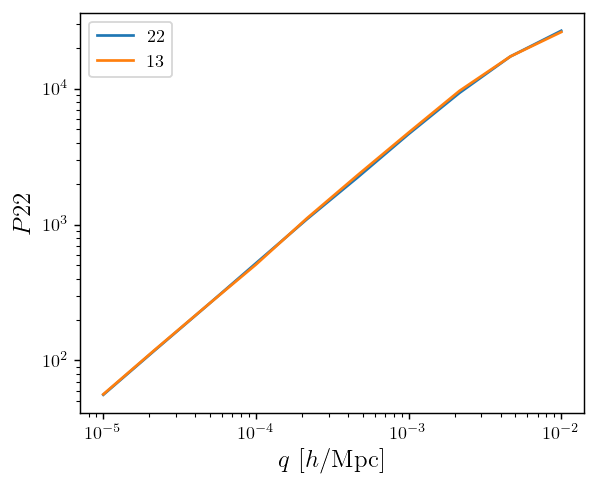

In [48]:
plt.figure(figsize=(5,4), dpi=130)
plt.loglog(qlist,reslist22,label='22')
plt.loglog(qlist,np.abs(np.array(reslist13)),label='13')
# plt.plot(qlist,(reslist22-np.abs(np.array(reslist13)))/reslist22,label='13')
# plt.axhline(0, color='k')
plt.xlabel(r"$q$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r'$P22$', fontsize=14)
plt.xscale('log')
plt.legend()

plt.show()